# Summary 

## Basic training and prediction 
* Note: Input df columns should be: 'ds' and 'y'

```python
# fit
m = Prophet()
m.fit(df)

# make prediction
future = m.make_future_dataframe(periods=24, freq='MS')  # period = each row 
forecast = m.predict(future)  # inlcudes train + predicted horizon

# plot all data
m.plot(forecast)

# plot components 
m.plot_components(forecast)  # has 1) trend, 2) yearly seasonality, 3) weekly seasonality, 4) daily seasonality
```  

## Cross validation

```python
# horizon: prediction horizon for each fold (how far how do you want to forecast?)
horizon = str(365) + ' days'
# initial: initial training period
initial = str(5 * 365) + ' days'  # use 5 years of daily data to train
# period: spacing between cutoff dates
period = str(5 * 365) + ' days'

# calculate cross validation 
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

# check performance metrics 
performance_metrics(df_cv)

# plot cross validation results
ax = plot_cross_validation_metric(df_cv, metric='rmse')
```


## Checking inflection points 
```python
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
```


## Additive vs. Multiplicative seasonality
```python
# change seasonality_mode to `additive` vs `multiplicative`
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)
```

In [1]:
import pandas as pd
from statsmodels.tools.eval_measures import rmse

from fbprophet import Prophet 
from fbprophet.diagnostics import cross_validation, performance_metrics 
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt

# 1. Basic training and prediction

In [2]:
df = pd.read_csv('../data/BeerWineLiquor.csv')

In [3]:
df.head()

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


The way the Prophet library works is that time column name should be 'ds' and y column name should be 'y'. So, we will rename the columns. Also, 'ds' column should be datetime object.

In [4]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

In [5]:
df.head()

,ds,y
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      324 non-null    datetime64[ns]
 1   y       324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [7]:
# fit model - ignore train/test split for now 
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


It did not find weekly or daily seasonality so it's disabled automatically. It makes sense because it is monthly data. If I know the data has weekly or daily seasonality, we can set the parameters to be True.

In [8]:
# future dataframe - placeholder object
future = m.make_future_dataframe(periods=24, freq='MS')  # one period = one row = 1 month for this data

In [9]:
# start of the future df is same as the original data 
future.head()

,ds
0,1992-01-01
1,1992-02-01
2,1992-03-01
3,1992-04-01
4,1992-05-01


In [10]:
# end of the future df is original + 24 periods (2 years)
future.tail()

,ds
343,2020-08-01
344,2020-09-01
345,2020-10-01
346,2020-11-01
347,2020-12-01


In [11]:
# predict the future on the model for the given future df 
forecast = m.predict(future)

In [12]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,1777.750825,1156.031371,1464.362943,1777.750825,1777.750825,-461.808985,-461.808985,-461.808985,-461.808985,-461.808985,-461.808985,0.0,0.0,0.0,1315.941840
1,1992-02-01,1780.417028,1196.510097,1529.751241,1780.417028,1780.417028,-426.178759,-426.178759,-426.178759,-426.178759,-426.178759,-426.178759,0.0,0.0,0.0,1354.238270
2,1992-03-01,1782.911219,1435.753109,1758.432372,1782.911219,1782.911219,-178.363746,-178.363746,-178.363746,-178.363746,-178.363746,-178.363746,0.0,0.0,0.0,1604.547472
3,1992-04-01,1785.577422,1424.494954,1762.471254,1785.577422,1785.577422,-195.905793,-195.905793,-195.905793,-195.905793,-195.905793,-195.905793,0.0,0.0,0.0,1589.671629
4,1992-05-01,1788.157619,1661.512076,1992.073619,1788.157619,1788.157619,45.003300,45.003300,45.003300,45.003300,45.003300,45.003300,0.0,0.0,0.0,1833.160919


/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


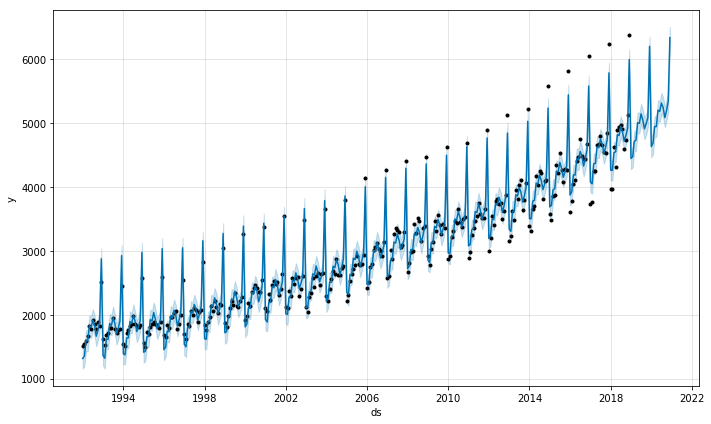

In [13]:
# Prophet's own plotting tool to see 
m.plot(forecast);

(735234.0, 737791.0)

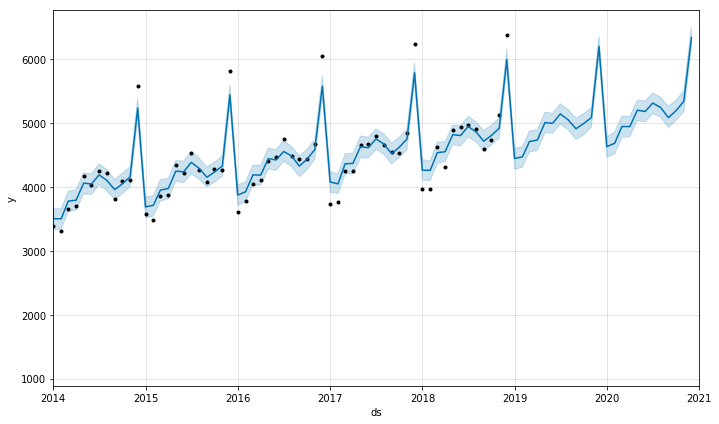

In [14]:
# zoom in for the prediction
m.plot(forecast);
plt.xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2021-01-01'))

/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


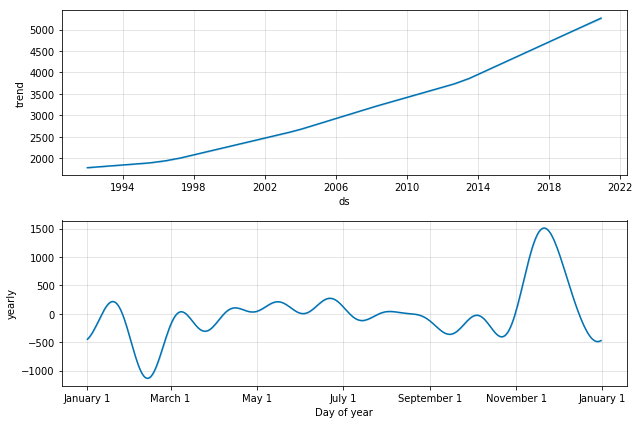

In [15]:
m.plot_components(forecast);

# 2. Evaluation

In [16]:
df = pd.read_csv('../Data/Miles_Traveled.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [18]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

In [19]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [20]:
df.tail()

,ds,y
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0
586,2018-11-01,258590.0
587,2018-12-01,268413.0


In [21]:
len(df)

588

## Normal way of calculating performance

In [22]:
train = df.iloc[:576]
test = df.iloc[576:]

In [23]:
# fit model 
m = Prophet(weekly_seasonality=False, daily_seasonality=False)
m.fit(train)

# create future data 
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

In [24]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263332.075594,274186.692869,285017.749773,263295.780575,263386.249028,16449.176404,16449.176404,16449.176404,16449.176404,16449.176404,16449.176404,0.0,0.0,0.0,279781.251998
584,2018-09-01,263472.647137,256383.757458,267120.142295,263409.017622,263556.437417,-1668.588186,-1668.588186,-1668.588186,-1668.588186,-1668.588186,-1668.588186,0.0,0.0,0.0,261804.058951
585,2018-10-01,263608.684114,263329.923467,274605.753777,263518.194214,263729.466862,5307.790802,5307.790802,5307.790802,5307.790802,5307.790802,5307.790802,0.0,0.0,0.0,268916.474916
586,2018-11-01,263749.255657,249944.377648,261789.034048,263629.360288,263912.630411,-8206.648040,-8206.648040,-8206.648040,-8206.648040,-8206.648040,-8206.648040,0.0,0.0,0.0,255542.607617
587,2018-12-01,263885.292634,250915.863196,262783.632748,263741.204307,264091.998702,-6919.794734,-6919.794734,-6919.794734,-6919.794734,-6919.794734,-6919.794734,0.0,0.0,0.0,256965.497900


/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


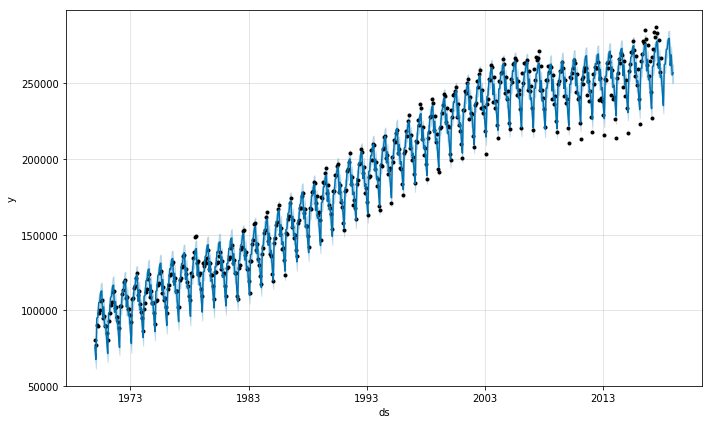

In [25]:
ax = m.plot(forecast)

(576, 588)

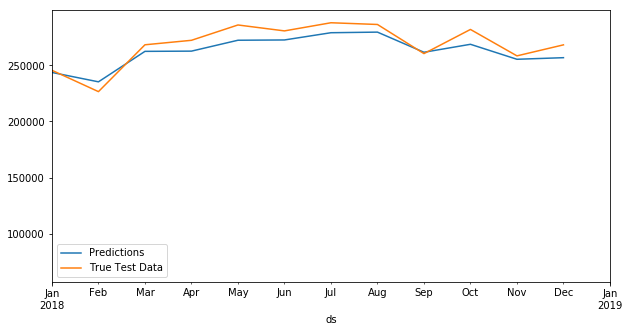

In [26]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(10, 5))
test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax)
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))

In [27]:
predictions = forecast.iloc[-12:]['yhat']
actuals = test['y']

rmse(predictions, actuals)

8672.829976541623

## Prophet's diagnostics tools

In [28]:
# horizon: prediction horizon for each fold (how far how do you want to forecast?)
horizon = str(365) + ' days'

# initial: initial training period
initial = str(5 * 365) + ' days'  # use 5 years of daily data to train

# period: spacing between cutoff dates
period = str(5 * 365) + ' days'


df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


In [29]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.087674,107150.623685,109936.572034,102445.0,1976-12-11
1,1977-02-01,102996.111722,101450.900018,104452.396544,102416.0,1976-12-11
2,1977-03-01,118973.318539,117360.439544,120265.981954,119960.0,1976-12-11
3,1977-04-01,120612.924126,118987.386560,122078.574984,121513.0,1976-12-11
4,1977-05-01,127883.032250,126475.741540,129388.994453,128884.0,1976-12-11
...,...,...,...,...,...,...
103,2017-08-01,273461.375852,267111.145971,278979.806868,283184.0,2016-12-01
104,2017-09-01,255582.789277,250039.575044,261481.200700,262673.0,2016-12-01
105,2017-10-01,262689.444631,256741.460412,268286.417999,278937.0,2016-12-01
106,2017-11-01,249341.802877,243670.541151,254852.431484,257712.0,2016-12-01


In [30]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,52 days,2.405780e+07,4904.874956,4508.576841,0.027641,0.023401,0.4
1,53 days,2.154158e+07,4641.290787,4240.548939,0.024871,0.023401,0.4
2,54 days,1.811659e+07,4256.358815,3715.480456,0.019975,0.022126,0.5
3,55 days,2.292300e+07,4787.797490,4231.785972,0.023010,0.023401,0.4
4,57 days,2.079789e+07,4560.470470,3973.876022,0.021322,0.022126,0.5
...,...,...,...,...,...,...,...
94,360 days,1.822290e+07,4268.829242,3743.237614,0.019547,0.019551,0.5
95,361 days,1.734359e+07,4164.564050,3471.144391,0.018186,0.018853,0.5
96,362 days,3.172965e+07,5632.907384,4402.292136,0.022008,0.024576,0.4
97,364 days,2.988951e+07,5467.129631,4229.675527,0.021360,0.021556,0.5


/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y =

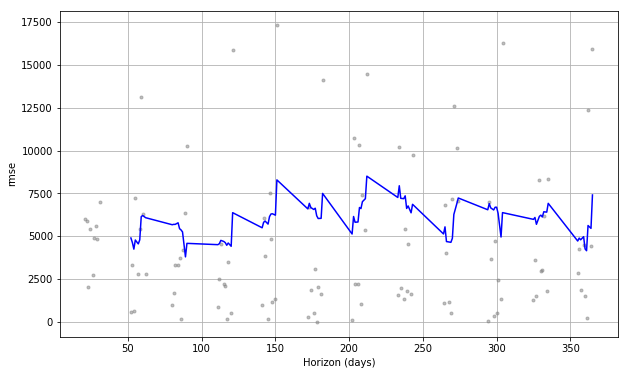

In [31]:
ax = plot_cross_validation_metric(df_cv, metric='rmse')

# 3. Trend

`Prophet` can also show trend change points.

In [32]:
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x =

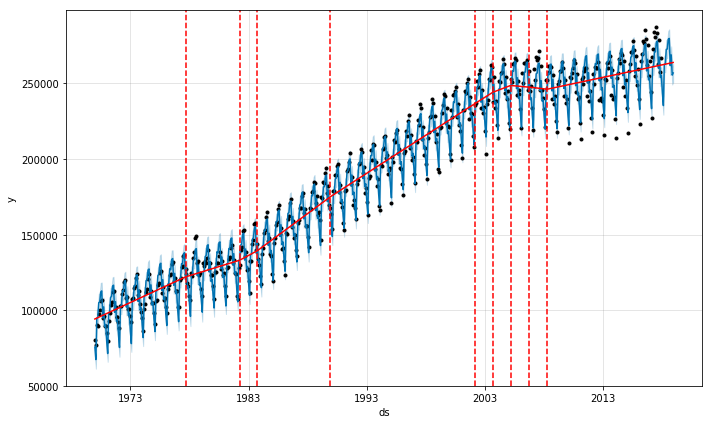

In [33]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# 4. Seasonality

The growth in trend can be additive (rate of change is linear) or multiplicative (rate changes over time). When you see the original data below, the amplitude of seasonality of the data is changing - smaller in the early years and bigger in the later years. So, this would be `multiplicative` growth case rather than `additive` growth case. We can adjust the `seasonality` parameter so we can take into account this effect. 

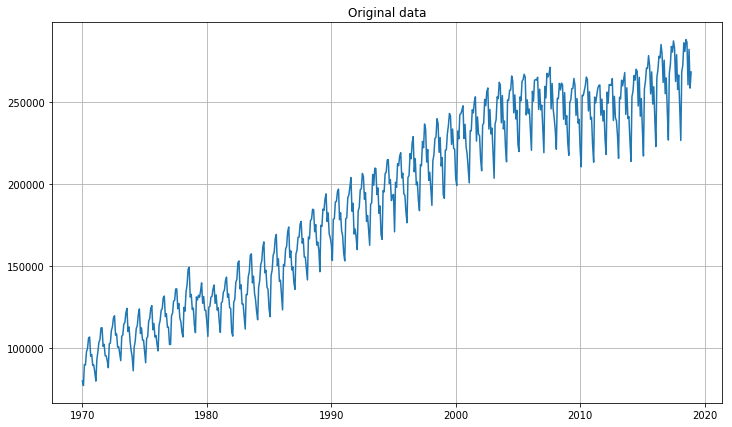

In [34]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(df['ds'], df['y'])
plt.title('Original data')
plt.grid(True)
plt.show()

/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


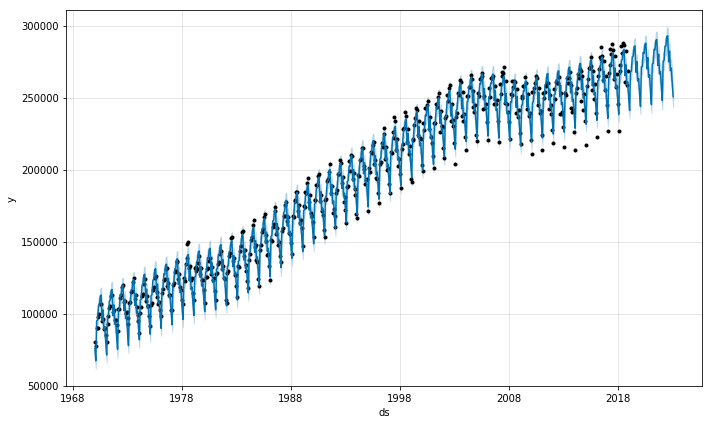

In [35]:
# additive mode
m = Prophet(seasonality_mode='additive', weekly_seasonality=False, daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/minkyung/Dropbox/mk-personal-repo/time-series-analysis/venv-timeseries/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


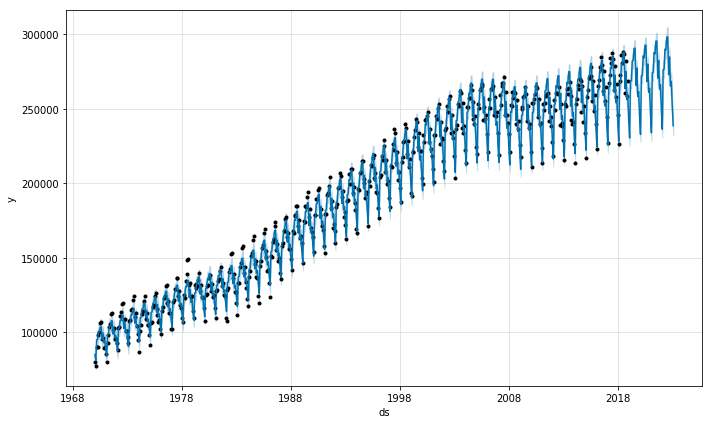

In [36]:
# multiplicative mode
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)